Objective
The purpose of this assignment is to give you an opportunity to demonstrate your technical aptitude,
problem-solving skill, and familiarity with the tools and techniques of data science.

In order to be respectful of your time, please limit yourself to no more than 3 hours. We recognize that
this is barely enough time to scratch the surface of the dataset—but hopefully it is enough time to build
a quick model and showcase your abilities.

Data
Last five years of building permit data from the City of Seattle. Data is publicly available at Seattle’s open
data repository here, which includes a handy data dictionary.

Exercises
Choose ONE of the analysis exercises below. Perform your work in the tool of your choice. Please be
sure to describe your process and specify any assumptions you make.
1. Regression Analysis – Build a model to predict ‘Value’ for a given permit.
2. Classification – Build a model to predict ‘Status’ for a given permit.
3. Forecasting – Build a model to predict future application volume. We define application volume
on a date as number of applications with that Application Date.

This is real data and it is therefore messy and incomplete. You are strongly encouraged to concentrate
on an interesting subset of it. For example, you may choose to remove all $0-value permits from the
dataset before you run your regression analysis.

Evaluation
Responses will be judged on the following criteria:

a. Approach: reasonable, well-thought- out

b. Technique: appropriate, correctly executed

c. Communication: clear, articulate, insightful

Remember, a null result is still a finding!

Regression Analysis – Build a model to predict ‘Value’ for a given permit.

Regularization

Cross validation

Train/Test Split

Univariate plots

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from uszipcode import ZipcodeSearchEngine
from sklearn.ensemble import GradientBoostingRegressor

## EDA, Data Cleaning, and Feature Engineering
My goal here is just to import the data and get a feel for how it is laid out, examine the various columns and data types, and see if there are any obvious correlations.

In [2]:
data = pd.read_csv('data/Building_Permits___Current.csv')

In [3]:
data.shape

(58546, 20)

In [4]:
data.head(2)

,Application/Permit Number,Permit Type,Address,Description,Category,Action Type,Work Type,Value,Applicant Name,Application Date,Issue Date,Final Date,Expiration Date,Status,Contractor,Permit and Complaint Status URL,Master Use Permit,Latitude,Longitude,Location
0,6640897,Demolition,700 22ND AVE,"Demolish existing church, per plan.",COMMERCIAL,DEMOLITION,Plan Review,$0.00,"SQUIRES, GREG",01/31/2018,03/06/2018,NaN,09/06/2019,Permit Issued,NaN,http://web6.seattle.gov/dpd/PermitStatus/Proje...,NaN,47.608206,-122.303402,"700 22ND AVE\n(47.60820558, -122.30340248)"
1,6648574,Demolition,5045 26TH AVE SW,"Demolish existing single-family residence, per...",SINGLE FAMILY / DUPLEX,DEMOLITION,No plan review,$0.00,"LEDOUX, JULIE",03/06/2018,NaN,NaN,NaN,Reviews Completed,NaN,http://web6.seattle.gov/dpd/PermitStatus/Proje...,NaN,47.556140,-122.365875,"5045 26TH AVE SW\n(47.55614034, -122.36587533)"


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58546 entries, 0 to 58545
Data columns (total 20 columns):
Application/Permit Number          58546 non-null int64
Permit Type                        58546 non-null object
Address                            58321 non-null object
Description                        58273 non-null object
Category                           55330 non-null object
Action Type                        55373 non-null object
Work Type                          58546 non-null object
Value                              58546 non-null object
Applicant Name                     58047 non-null object
Application Date                   44900 non-null object
Issue Date                         38065 non-null object
Final Date                         26240 non-null object
Expiration Date                    38163 non-null object
Status                             54456 non-null object
Contractor                         10670 non-null object
Permit and Complaint Status URL    58

In [6]:
data.describe()

,Application/Permit Number,Master Use Permit,Latitude,Longitude
count,5.854600e+04,7.559000e+03,58316.000000,58316.000000
mean,6.450874e+06,3.017908e+06,47.625656,-122.334609
std,1.371412e+05,6.291356e+03,0.054128,0.037260
min,6.061738e+06,3.001370e+06,47.495860,-122.430368
25%,6.378788e+06,3.014229e+06,47.586212,-122.362699
50%,6.468130e+06,3.017469e+06,47.625888,-122.333810
75%,6.558800e+06,3.022792e+06,47.669715,-122.305791
max,6.649331e+06,3.031180e+06,47.733970,-122.236509


I converted the value from a string to a float to ease analysis

In [7]:
data['Value'] = data.apply(lambda row: pd.to_numeric(row['Value'][1:]), axis=1)

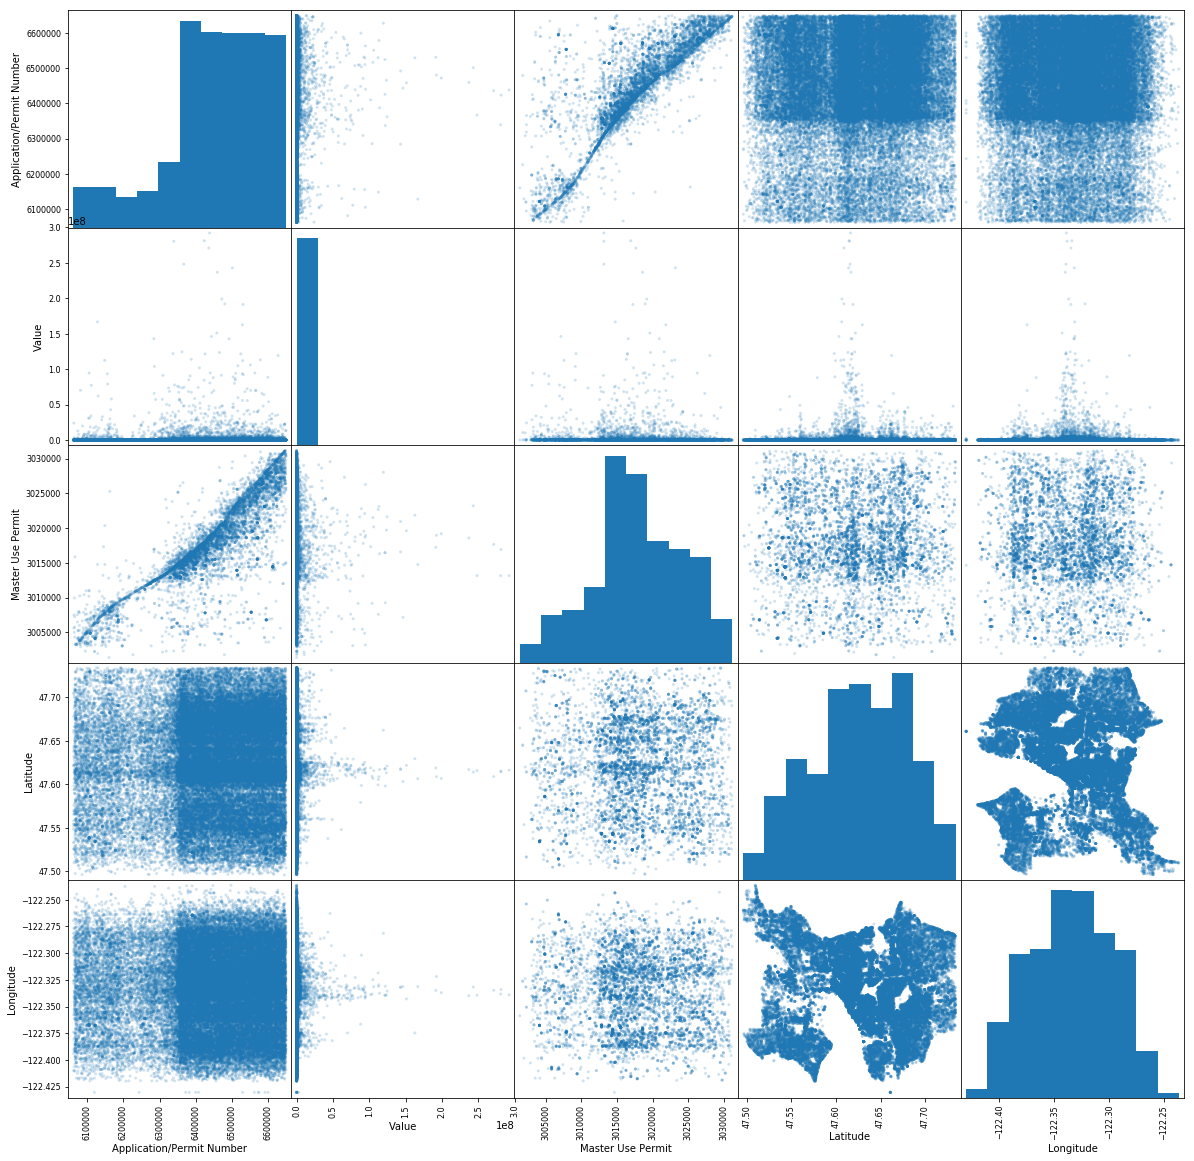

In [8]:
_ = scatter_matrix(data, alpha=0.2, figsize=(20, 20))

I have chosed to drop the following columns from the data set.

In [9]:
columns_to_drop = ['Application/Permit Number', 'Address', 'Description', 'Applicant Name', 'Permit and Complaint Status URL', 'Location']

I believe that this makes intuitive sense for the following reasons:
    * Application/Permit Number - I'm assuming that this is not correlated with value as it is assigned arbitrarily or in sequence.
    * Address - While location of the building permits would intuitively be linked to value, this information is captured in the latitude and longitude columns.
    * Description - Using NLP processing on this column could be interesting, but in the interest of time and interpretability, I am removing it for now.
    * Applicant Name - It appears that only four people are listed >500 times as the applicant. There could be some sort of correlation here if one builder only works with high-value projects, but overall, I am assuming that this is not correlated given the low number of repeat applicants.
    * Permit and Complaint Status URL - The URL string would bear no correlation with the permit value given the nature of URLs.
    * Location - This information is already included in the address and the latitude and longitude.

In [10]:
data2 = data.drop(columns_to_drop, axis=1)

In [11]:
data2[data2['Application Date'].isna()]['Value'].value_counts().iloc[0:10]

0.0         12848
1000.0         36
1.0            33
50000.0        25
20000.0        25
5000.0         23
10000.0        22
25000.0        19
15000.0        18
200000.0       14
Name: Value, dtype: int64

As it appears that the vast majority of permits for which the Application Date is not yet recorded are valued at $0, I have chosen to remove all records for which the Application Date was n/a. This makes some intuitive sense given the definition of Application Date, shown below:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The date the application was accepted as a complete submittal. If no Application Date exists this generally means the application is in a very early stage.

In [12]:
data3 = data2[data2['Application Date'].isna() == False].copy()

While I don't believe that the values in the Master Use Permit column (this appears to be a permit number if a master use permit exists), or the Contractor column (this appears to be the name of the contractor if there is one) are very predictive on their own (except perhaps with contractors that appear multiple times) -- I think that there could be value in identifying if a permit has a master use permit or a contractor. As such, I'm turning the columns into bool values.

In [13]:
columns_to_bool = ['Master Use Permit', 'Contractor']

In [14]:
data3['has_master_use_permit'] = data3['Master Use Permit'].isna() == False

In [15]:
data3['has_contractor'] = data3['Contractor'].isna() == False

In [16]:
data4 = data3.drop(columns_to_bool, axis=1)

The columns listed in columns_to_dummy below appear to contain discrete values. By adding dummy variables, I will be able to capture the possible prediction power of these items in my regression analysis.

In [17]:
columns_to_dummy = ['Status', 'Work Type', 'Action Type', 'Category', 'Permit Type']

In [18]:
data5 = pd.get_dummies(data4, columns=columns_to_dummy)

## ASIDE

In [289]:
test_data = data5[data5['Final Date'].isna() == False].copy()

In [290]:
test_data['final_date_year'] = test_data.apply(lambda row: pd.to_datetime(row['Final Date']).year, axis=1)

In [291]:
filtered_test_data = test_data[test_data['final_date_year'] >= 2014].copy()

In [292]:
filtered_test_data['has_expiration_date'] = (filtered_test_data['Expiration Date'].isna() == False)

In [293]:
filtered_test_data = filtered_test_data.drop(['Application Date', 'Issue Date', 'Final Date', 'Expiration Date'], axis=1)

In [294]:
search = ZipcodeSearchEngine()

In [295]:
filtered_test_data['zipcode'] = filtered_test_data.apply(lambda row: 
                               search.by_coordinate(row['Latitude'], 
                                                    row['Longitude'], 
                                                    radius=5, 
                                                    returns=1)[0]['Zipcode'], 
                               axis=1)

In [296]:
filtered_test_data = pd.get_dummies(filtered_test_data, ['zipcode'])

In [297]:
filtered_test_data = filtered_test_data.drop(['Latitude', 'Longitude'], axis=1)

In [298]:
filtered_test_data = filtered_test_data[filtered_test_data['Value'] > 0]

In [349]:
X = filtered_test_data.drop(['Value'], axis=1).values
y = filtered_test_data['Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [338]:
lasso_regularization_strengths = np.logspace(np.log10(100), np.log10(1000000), num=100)

lasso_regressions = []
for alpha in lasso_regularization_strengths:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    lasso_regressions.append(lasso)

/Users/ReddingSkinnyRobot/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [339]:
def plot_solution_paths(ax, regressions):
    alphas = [np.log10(ridge.alpha) for ridge in regressions]
    coeffs = np.concatenate([ridge.coef_.reshape(1, -1) 
                             for ridge in regressions])
    for idx in range(coeffs.shape[1]):
        ax.plot(alphas, coeffs[:, idx])
    ax.set_xlabel(r"$\log_{10}(\alpha)$")
    ax.set_ylabel("Estiamted Coefficient")
    ax.set_title("Coefficient Paths")

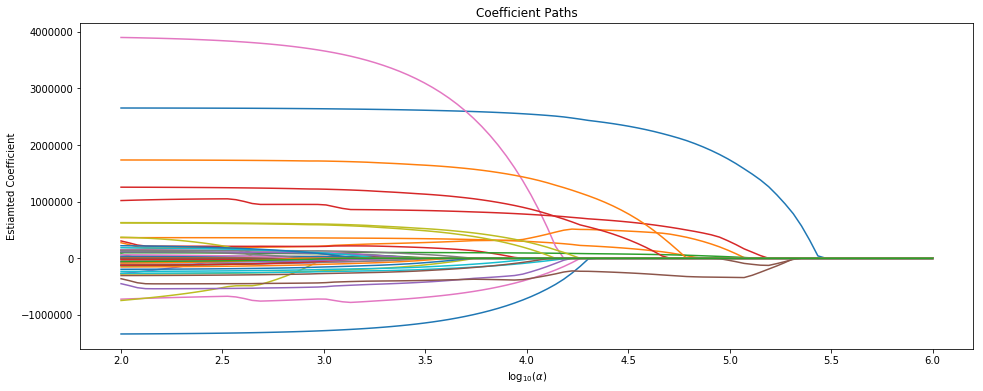

In [340]:
fig, ax = plt.subplots(figsize=(16, 6))
plot_solution_paths(ax, lasso_regressions)

In [315]:
def rss(model, X, y):
    preds = model.predict(X)
    n = X.shape[0]
    return np.sum((y - preds)**2) / n

def train_and_test_error(regressions, X_train, y_train, X_test, y_test):
    alphas = [ridge.alpha for ridge in regressions]
    train_scores = [rss(reg, X_train, y_train) for reg in regressions]
    test_scores = [rss(reg, X_test, y_test) for reg in regressions]
    return pd.DataFrame({
        'train_scores': train_scores,
        'test_scores': test_scores,
    }, index=alphas)

def get_optimal_alpha(train_and_test_errors):
    test_errors = train_and_test_errors["test_scores"]
    optimal_idx = np.argmin(test_errors.values)
    return train_and_test_errors.index[optimal_idx]

def plot_train_and_test_error(ax, train_and_test_errors, alpha=1.0, linewidth=2, legend=True):
    alphas = train_and_test_errors.index
    optimal_alpha = get_optimal_alpha(train_and_test_errors)
    ax.plot(np.log10(alphas), train_and_test_errors.train_scores, label="Train MSE",
            color="blue", linewidth=linewidth, alpha=alpha)
    ax.plot(np.log10(alphas), train_and_test_errors.test_scores, label="Test MSE",
            color="red", linewidth=linewidth, alpha=alpha)
    ax.axvline(x=np.log10(optimal_alpha), color="grey", alpha=alpha)
    ax.set_xlabel(r"$\log_{10}(\alpha)$")
    ax.set_ylabel("Mean Squared Error")
    ax.set_title("Mean Squared Error vs. Regularization Strength")
    if legend:
        ax.legend()

In [350]:
train_and_test_errors = train_and_test_error(
    lasso_regressions, X_train, y_train, X_test, y_test)

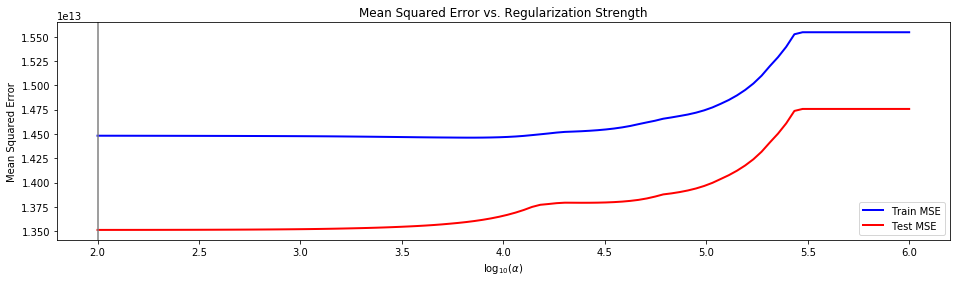

In [351]:
fig, ax = plt.subplots(figsize=(16, 4))
plot_train_and_test_error(ax, train_and_test_errors)

In [343]:
lasso_optimal_alpha = get_optimal_alpha(train_and_test_errors)

In [344]:
final_lasso_model = Lasso(alpha=lasso_optimal_alpha)
final_lasso_model.fit(X, y)

Lasso(alpha=97700.995729922462, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [347]:
from sklearn.model_selection import KFold

In [362]:
def rmse(true, predicted):
    return ((predicted-true)**2).mean()**0.5

In [365]:
from sklearn.ensemble import GradientBoostingRegressor

In [366]:
gdbr = GradientBoostingRegressor(learning_rate=0.1,
                                  loss='ls',
                                  n_estimators=100,
                                  random_state=1)

In [367]:
gdbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=1,
             subsample=1.0, verbose=0, warm_start=False)

In [369]:
r2_score = cross_val_score(gdbr, X, y, cv=5).mean()
mse_score = -(cross_val_score(gdbr, X, y, scoring='neg_mean_squared_error', cv=5).mean())

In [370]:
r2_score

-0.097691688715635758

In [371]:
mse_score

14264512029268.443

In [346]:
final_lasso_model.score(X, y)

0.04723763242217438

In [280]:
X = filtered_test_data.drop(['Value'], axis=1).values
y = filtered_test_data['Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
linear = LinearRegression()
linear.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [281]:
linear.score(X_train, y_train)

0.062524953270008066

In [282]:
linear.score(X_test, y_test)

-4.2065395680071765e+20

In [285]:
list(filtered_test_data.columns) - list(['Value'])

TypeError: unsupported operand type(s) for -: 'list' and 'list'

### End Aside

To further narrow down my dataset, I have chosen to limit my data to only those records with an Issue_date within the last three years. Given the increasing value of the houseing market in the Seattle area in the last five years, as well as the fact that the listed Value is an estimate of the fair market value of the permit per the King County website, I believe that this is reasonable.

In [20]:
data5['issue_date_year'] = data5.apply(lambda row: pd.to_datetime(row['Issue Date']).year, axis=1)

In [21]:
data6 = data5[data5['issue_date_year'] >= 2014].copy()

I've also decided to dummy the issue_date_year columns as this could be correlated to the value.

In [22]:
data7 = pd.get_dummies(data6, columns=['issue_date_year'])

#In reviewing the Application Date, Issue Date, Final Date, and Expiration Date columns, I've chosen to remove them. I will instead replace them will bool values to indicate if there is an application date, issue date, etc. This will simplify my regression at the moment, but as I realize that yearly and quarterly data could correlate with the permit Value, this could be an area to come back to for further analysis. 

#As I have already removed all records for which the application date was non-existant, I can also remove the application data columns entirely, as all remaining records will have a True value for if the application date exists or not.

In [386]:
#data7['has_issue_date'] = (data7['Issue Date'].isna() == False)
#data7['has_final_date'] = (data7['Final Date'].isna() == False)
#data7['has_expiration_date'] = (data7['Expiration Date'].isna() == False)

In [23]:
data8 = data7.drop(['Application Date', 'Issue Date', 'Final Date', 'Expiration Date'], axis=1)

I want to use the latitude and longitude in my regression analysis to allow my model to predict based on the location of the permit which I believe makes some intuitive sense given the geographic nature of construction permits and my assumption that their values vary based on where they are located. To do this I converted the latitude and longitude of the records that remained to zip codes and created dummy columns for the zip codes.

In [25]:
search = ZipcodeSearchEngine()

In [26]:
data8['zipcode'] = data8.apply(lambda row: 
                               search.by_coordinate(row['Latitude'], 
                                                    row['Longitude'], 
                                                    radius=5, 
                                                    returns=1)[0]['Zipcode'], 
                               axis=1)

In [27]:
data9 = pd.get_dummies(data8, ['zipcode'])

In [28]:
data10 = data9.drop(['Latitude', 'Longitude'], axis=1)

Lastly, I removed all records for which to Value was $0. I did this to further subset my data and concentrate my analysis.

In [29]:
data11 = data10[data10['Value'] > 0]

In [30]:
cleaned_data = data11.copy()

## Model Creation

In [32]:
X = cleaned_data.drop(['Value'], axis=1).values

In [33]:
y = cleaned_data['Value']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [37]:
gradient_boosting_grid = {'learning_rate': [0.1],
                          'subsample': [0.50],
                          'max_depth': [2, 3, 4, 5],
                          'min_samples_leaf': [2, 4],
                          'max_features': ['sqrt', 'log2', None],
                          'n_estimators': [1000],
                          'random_state': [1]}
    
gb_gridsearch = GridSearchCV(GradientBoostingRegressor(),
                             gradient_boosting_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='neg_mean_squared_error',
                             cv=10)

I would have used a smaller learning rate (0.01), but for time's sake, I have reduced it to 0.1.

In [ ]:
gb_gridsearch.fit(X_train, y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min


In [ ]:
print("best parameters:", gb_gridsearch.best_params_)

best_gb_model = gb_gridsearch.best_estimator_

Possible future work:
    1. Work further with the time series data in in the Applicaiton, Issue, Final, and Expiration dates.
    2. NLP processing on the Description column.
    3. Find correlation with duplicate contractors or applicants
    4. Write a script to process the data before it is fed into a model for future permit valuations